In [26]:
import sys
sys.path.append('../')
sys.path.append('../trainruns')
import diagnostics
from pathlib import Path
import numpy as np
from diagnostics import ks, torch, odeint, color_palette
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtransforms

from KS import KS

plt.rcParams.update({
    "text.usetex": True,
    "font.size": '16',
})

color_palette = sns.color_palette("colorblind")

In [27]:
pos = diagnostics.experiment.pos

In [28]:
exp_parent = Path(f"/ptmp/nbudanur/KS/public/po1/ctrans_3.60e+00/")
parameters_path = list(exp_parent.glob('**/parameters.txt'))[0]

In [29]:
pars = diagnostics.read_parameters(parameters_path)

In [30]:
dataset = diagnostics.get_dataset(pars)

In [31]:
conjnet = diagnostics.get_conjnet(pars)

no kom parameter found, setting kom=0


In [32]:
ks = KS(L=22.0, K=15, dt=0.01)

In [33]:
help(diagnostics.visualize_data)

Help on function visualize_data in module diagnostics:

visualize_data(data, ipo, pos, ni=0, nf=1000, ax=None, c_zoom=0.8)
    visualize the training dataset. 
    data should either be a FlowDataset object or a hdf5 file



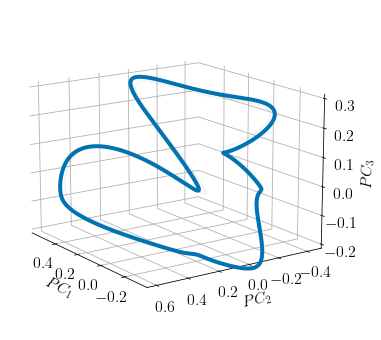

In [34]:
_ = diagnostics.visualize_data(dataset, ipo=1, pos=pos, ni=0, nf=1);

In [35]:
po = '32.80'
dt = 0.01
L = 22.0

xi_p = pos[po]['xi_p']
T_p = pos[po]['T_p']

tt_p = np.arange(0, T_p, dt)
sol_po = odeint(ks.rhs, xi_p, tt_p)

sol_po_ = ks.symmreduce(sol_po)
torch_sol_po_ = torch.tensor(sol_po_)

latent_po = conjnet.encoder(torch_sol_po_).detach().numpy()

power_in_po = ks.power_in(sol_po)
dissip_po = ks.dissipation(sol_po)

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


/tmp/ipykernel_96970/3095562251.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[label].set_yticklabels(yticklabels)


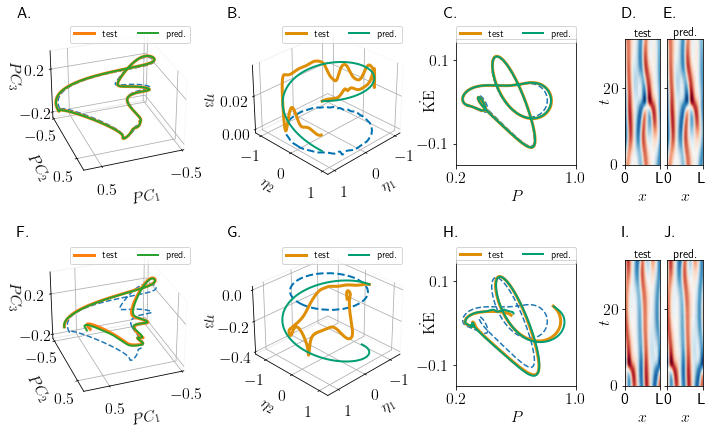

In [42]:
# Create layout
layout = [
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "U", "U", "U", "Z", "W", "W"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "V", "V", "V", "Z", "T", "T"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "V", "V", "V", "Z", "T", "T"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "P", "P", "P", "Z", "S", "S"],    
]
fig, axd = plt.subplot_mosaic(layout, figsize=(12,8))

# by default all axes are 2d, below is a hack to make A 3d:

for label in ['A', 'B', 'F', 'G']:
    specs = axd[label].get_subplotspec()
    axd[label].remove()
    axd[label] = fig.add_subplot(specs, projection='3d')
    ax = axd[label]

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.fill = False

i_traj = 1000

po = list(pos)[0]
pca = pos[po]['pca']

sol_test_, tt_test = dataset.trajectories[i_traj]
rec_sol_test = ks.reconst_sol(sol_test_, tt_test, alpha_th=0.9)
power_in_test = ks.power_in(rec_sol_test)
dissip_test = ks.dissipation(rec_sol_test)

torch_sol_test_ = torch.tensor(sol_test_)
latent_sol_test = conjnet.encoder(torch_sol_test_).detach().numpy()

xi_test = sol_test_[0, :]

indata = torch.tensor(
    np.insert(np.ones(sol_test_.shape) * xi_test, 0, tt_test, axis=1)
    )
prediction = conjnet(indata.double())
sol_pred_ = prediction.detach().cpu().numpy()

rec_sol_pred = ks.reconst_sol(sol_pred_, tt_test, alpha_th=0.9)
power_in_pred = ks.power_in(rec_sol_pred)
dissip_pred = ks.dissipation(rec_sol_pred)

latent_pred = conjnet.et_t.detach().numpy()

sol_pred_pca = pca.transform(sol_pred_)
sol_test_pca = pca.transform(sol_test_)

axd['A'].plot(pos[po]['sol_pca'][:, 0], pos[po]['sol_pca'][:,1], pos[po]['sol_pca'][:,2], '--')
axd['A'].plot(sol_test_pca[:,0], sol_test_pca[:,1], sol_test_pca[:,2], lw=3.0, label='test')
axd['A'].plot(sol_pred_pca[:,0], sol_pred_pca[:,1], sol_test_pca[:,2], lw=2.0, label='pred.')

axd['B'].plot(latent_po[:, 0], latent_po[:, 1], latent_po[:, 2], color=color_palette[0], lw=2.0, linestyle='--')
axd['B'].plot(
    latent_sol_test[:, 0], latent_sol_test[:, 1], latent_sol_test[:, 2], 
    color=color_palette[1], lw=3.0, label='test'
)
axd['B'].plot(
    latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2], 
    color=color_palette[2], lw=2.0, label='pred.'
)

axd['C'].plot(power_in_po, power_in_po - dissip_po, '--')
axd['C'].plot(power_in_test, power_in_test - dissip_test, color=color_palette[1], lw=3.0, label='test')
axd['C'].plot(power_in_pred, power_in_pred - dissip_pred, color=color_palette[2], lw=2.0, label='pred.')

ks.plot_spacetime(rec_sol_test, tt_test, ax=axd['D'], vmin=-0.095, vmax=0.095)
ks.plot_spacetime(rec_sol_pred, tt_test, ax=axd['E'], vmin=-0.095, vmax=0.095)

i_traj = 1015

pca = pos[po]['pca']

sol_test_, tt_test = dataset.trajectories[i_traj]
rec_sol_test = ks.reconst_sol(sol_test_, tt_test, alpha_th=0.9)
power_in_test = ks.power_in(rec_sol_test)
dissip_test = ks.dissipation(rec_sol_test)

torch_sol_test_ = torch.tensor(sol_test_)
latent_sol_test = conjnet.encoder(torch_sol_test_).detach().numpy()

xi_test = sol_test_[0, :]

indata = torch.tensor(
    np.insert(np.ones(sol_test_.shape) * xi_test, 0, tt_test, axis=1)
    )
prediction = conjnet(indata.double())
sol_pred_ = prediction.detach().cpu().numpy()

rec_sol_pred = ks.reconst_sol(sol_pred_, tt_test, alpha_th=0.9)
power_in_pred = ks.power_in(rec_sol_pred)
dissip_pred = ks.dissipation(rec_sol_pred)

latent_pred = conjnet.et_t.detach().numpy()

sol_pred_pca = pca.transform(sol_pred_)
sol_test_pca = pca.transform(sol_test_)

axd['F'].plot(pos[po]['sol_pca'][:, 0], pos[po]['sol_pca'][:,1], pos[po]['sol_pca'][:,2], '--')
axd['F'].plot(sol_test_pca[:,0], sol_test_pca[:,1], sol_test_pca[:,2], lw=3.0, label='test')
axd['F'].plot(sol_pred_pca[:,0], sol_pred_pca[:,1], sol_test_pca[:,2], lw=2.0, label='pred.')

axd['G'].plot(latent_po[:, 0], latent_po[:, 1], latent_po[:, 2], color=color_palette[0], lw=2.0, linestyle='--')
axd['G'].plot(latent_sol_test[:, 0], latent_sol_test[:, 1], latent_sol_test[:, 2], 
              color=color_palette[1], lw=3.0, label='test')
axd['G'].plot(latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2], color=color_palette[2], lw=2.0, label='pred.')

axd['H'].plot(power_in_po, power_in_po - dissip_po, '--')
axd['H'].plot(power_in_test, power_in_test - dissip_test, color=color_palette[1], lw=3.0, label='test')
axd['H'].plot(power_in_pred, power_in_pred - dissip_pred, color=color_palette[2], lw=2.0, label='pred.')

ks.plot_spacetime(rec_sol_test, tt_test, ax=axd['I'], vmin=-0.095, vmax=0.095)
ks.plot_spacetime(rec_sol_pred, tt_test, ax=axd['J'], vmin=-0.095, vmax=0.095)

for ax in [axd['B'], axd['G']]:
    ax.set_xlabel("$\eta_1$")
    ax.set_ylabel("$\eta_2$")
    ax.set_zlabel("$\eta_3$       ")

for ax in [axd['D'], axd['E'], axd['I'], axd['J']]:
    ax.set_xticks([0, 22.0])
    ax.set_xticklabels(['0', 'L  '])

# fig.tight_layout()

for label in ['U', 'V', 'X', 'Y', 'Z', 'W', 'S', 'P', 'T']:
    axd[label].set_visible(False)

for label in ['A', 'B', 'C', 'D', 'E']:
        
    ax = axd[label]
    label_x = ax.transAxes.transform([-0.1, 1]) # to display coordinates
    label_x = fig.transFigure.inverted().transform(label_x)[0] # display->fig.
    
    if label in ['A', 'B']:
        ax.text2D(label_x, 0.84, f"{label}.", transform=fig.transFigure)
    else:
        ax.text(label_x, 0.84, f"{label}.", transform=fig.transFigure)
        

for label in ['F', 'G', 'H', 'I', 'J']:
        
    ax = axd[label]
    label_x = ax.transAxes.transform([-0.1, 1]) # to display coordinates
    label_x = fig.transFigure.inverted().transform(label_x)[0] # display->fig.
    
    if label in ['F', 'G']:
        ax.text2D(label_x, 0.46, f"{label}.", transform=fig.transFigure)
    else:
        ax.text(label_x, 0.46, f"{label}.", transform=fig.transFigure)
        
for label in ['A', 'F']: 
    c_zoom = 0.9
    ax = axd[label]
    ax.view_init(30, 70)
    ax.set_xlim(
        ax.get_xlim()[0] * c_zoom, 
        ax.get_xlim()[1] * c_zoom
        )
    ax.set_ylim(
        ax.get_ylim()[0] * c_zoom, 
        ax.get_ylim()[1] * c_zoom
        )
    ax.set_zlim(
        ax.get_zlim()[0] * c_zoom, 
        ax.get_zlim()[1] * c_zoom
        )
    ax.set_zticks([-.2, .2])
    ax.set_xticks([-.5, .5])
    ax.set_yticks([-.5, .5])

    ax.set_xlabel("$PC_1$")
    ax.set_ylabel("$PC_2$")
    ax.set_zlabel("       $PC_3$")
    
for label in ['B', 'G']:
    axd[label].view_init(30,45)

for label in ['A', 'F']:
    axd[label].legend(fontsize=10, ncol = 2)

for label in ['B', 'G']:
    axd[label].legend(fontsize=10, loc=1, ncol = 2)
        
for label in ['C', 'H']:
    ax=axd[label]
    ax.legend(loc=9, fontsize=10, ncol=2, bbox_to_anchor=(0.5, 1.15))
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(-0.15, 0.15)
    ax.set_xticks([0.2, 1.0])
    ax.set_yticks([-0.1, 0.1])
#     ax.plot([0.2, 1.0], [0.2, 1.0], 'k-', lw=1.0, zorder=-5)
    
    ax.set_xlabel("$P$")
    ax.set_ylabel("$\dot{\mathrm{KE}}$", labelpad=-20)

axd['D'].set_ylabel('                     $t$',labelpad=-10)
axd['I'].set_ylabel('                     $t$',labelpad=-10)
axd['D'].set_xlabel('$x$')
axd['I'].set_xlabel('$x$')

axd['D'].set_title('test', fontsize=12, pad=-1)
axd['I'].set_title('test', fontsize=12, pad=-1)
axd['E'].set_title('pred.', fontsize=12, pad=-1)
axd['J'].set_title('pred.', fontsize=12, pad=-1)

for label in ['E', 'J']:
    axd[label].set_ylabel('')
    yticks = axd[label].get_yticks()
    yticklabels = []
    for tick in yticks:
        yticklabels.append('')
    axd[label].set_yticklabels(yticklabels)
    axd[label].set_xlabel("$x$")

fig.savefig("test_po1.png", dpi=200)

In [43]:
!/mpcdf/soft/SLE_15/packages/x86_64/imagemagick/7.1.1/bin/convert -trim test_po1.png ../tex/fig/test_po1.png

In [38]:
ax.get_xlim()

(0.2, 1.0)